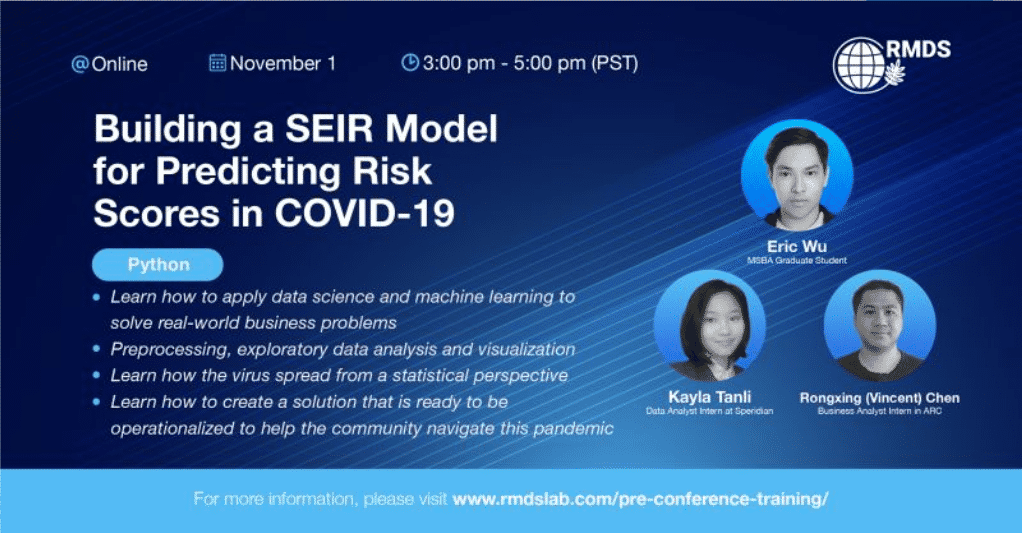

## **Workshop: Builiding an SEIR model for Predicting risk score in covid-19**

IM DATA meetin 2020 Pre-conference workshop #4

> Speakers: Team LMU MSBA (Vincent Chen, Kayla Tanli, Eric Wu)

> Loyola MaryMount University, Master of Business Analytic Program

> Instructor: Zhen (Richard) Tang



# **Data Preparation**

In [1]:
#import packages

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('ggplot')                  #for plotting

from scipy.integrate import odeint       #for handling differential equations

from datetime import datetime            #for handling time format

In [2]:
#import dataset

dataset_url = "https://raw.githubusercontent.com/qazwer564/Public-files/main/SEIR_workshop/latimes-county-totals-10-30.csv"

#data from LA times, death and confirmed cases for counties within California, up to Oct 30th

#use links from github, google drive (mount your drive) or upload yourself!

#read the dataset
total_cases = pd.read_csv(dataset_url)

total_cases

,date,county,fips,confirmed_cases,deaths,new_confirmed_cases,new_deaths
0,2020-10-30,Alameda,1,23775,463,139.0,0.0
1,2020-10-30,Alpine,3,8,0,0.0,0.0
2,2020-10-30,Amador,5,311,15,3.0,0.0
3,2020-10-30,Butte,7,3144,53,17.0,0.0
4,2020-10-30,Calaveras,9,354,21,7.0,0.0
...,...,...,...,...,...,...,...
13541,2020-01-26,Solano,95,0,0,NaN,NaN
13542,2020-01-26,Sonoma,97,0,0,NaN,NaN
13543,2020-01-26,Stanislaus,99,0,0,NaN,NaN
13544,2020-01-26,Ventura,111,0,0,NaN,NaN


In [3]:
#inspect the dataset

total_cases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13546 entries, 0 to 13545
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   date                 13546 non-null  object 
 1   county               13546 non-null  object 
 2   fips                 13546 non-null  int64  
 3   confirmed_cases      13546 non-null  int64  
 4   deaths               13546 non-null  int64  
 5   new_confirmed_cases  13488 non-null  float64
 6   new_deaths           13488 non-null  float64
dtypes: float64(2), int64(3), object(2)
memory usage: 740.9+ KB


Date is not in date format, we would change it later

In [4]:
#Perform a Data Quality Analysis to find missing values, NaNs etc.
print(total_cases.isnull().sum())


date                    0
county                  0
fips                    0
confirmed_cases         0
deaths                  0
new_confirmed_cases    58
new_deaths             58
dtype: int64


In [5]:
#select data we need

la_cases = total_cases[total_cases['county']=='Los Angeles'][['date','county','confirmed_cases','deaths']]
la_cases.head()

,date,county,confirmed_cases,deaths
18,2020-10-30,Los Angeles,306388,7057
76,2020-10-29,Los Angeles,305125,7044
134,2020-10-28,Los Angeles,303520,7043
192,2020-10-27,Los Angeles,302102,7027
250,2020-10-26,Los Angeles,300662,7000


In [6]:
#use reindex to rolocate rows

index_num = la_cases.date.sort_values().index

la_cases = la_cases.reindex(index_num)

la_cases

,date,county,confirmed_cases,deaths
13528,2020-01-26,Los Angeles,1,0
13521,2020-01-27,Los Angeles,1,0
13518,2020-01-28,Los Angeles,1,0
13515,2020-01-29,Los Angeles,1,0
13512,2020-01-30,Los Angeles,1,0
...,...,...,...,...
250,2020-10-26,Los Angeles,300662,7000
192,2020-10-27,Los Angeles,302102,7027
134,2020-10-28,Los Angeles,303520,7043
76,2020-10-29,Los Angeles,305125,7044


In [7]:
#change date format and set date as index

la_cases['date'] = pd.to_datetime(la_cases['date'])

la_cases = la_cases.set_index(['date'])

la_cases

,county,confirmed_cases,deaths
date,,,
2020-01-26,Los Angeles,1,0
2020-01-27,Los Angeles,1,0
2020-01-28,Los Angeles,1,0
2020-01-29,Los Angeles,1,0
2020-01-30,Los Angeles,1,0
...,...,...,...
2020-10-26,Los Angeles,300662,7000
2020-10-27,Los Angeles,302102,7027
2020-10-28,Los Angeles,303520,7043


In [8]:
#cutoff our data by selecting a date

national_emgergency_date = '2020-03-24'

national_emgergency_date = datetime.strptime(national_emgergency_date, '%Y-%m-%d')

la_cases = la_cases[la_cases.index >= national_emgergency_date]

la_cases

,county,confirmed_cases,deaths
date,,,
2020-03-24,Los Angeles,670,10
2020-03-25,Los Angeles,814,13
2020-03-26,Los Angeles,1230,21
2020-03-27,Los Angeles,1482,26
2020-03-28,Los Angeles,1818,32
...,...,...,...
2020-10-26,Los Angeles,300662,7000
2020-10-27,Los Angeles,302102,7027
2020-10-28,Los Angeles,303520,7043


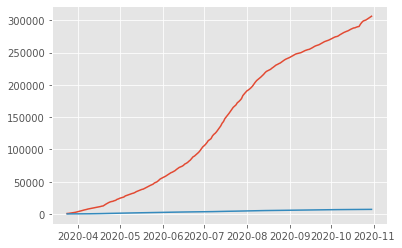

In [9]:
#simple plot

plt.plot(la_cases['confirmed_cases'])
plt.plot(la_cases['deaths'])

# **Model Setup**

In [10]:
#the essence of the whole model

# The SEIR model differential equations.

def deriv(y, t, N, beta, gamma, delta):
    S, E, I, R = y
    dSdt = -beta * S * I / N
    dEdt = beta * S * I / N - delta * E
    dIdt = delta * E - gamma * I
    dRdt = gamma * I
    return dSdt, dEdt, dIdt, dRdt


In [11]:
#building the model for plotting

def plotseird(t, S, E, I, R, D=None, Alpha=None):
  f, ax = plt.subplots(1,1,figsize=(10,4))
  ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
  ax.plot(t, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
  ax.plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected')
  ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')

#for death numbers from the removed group
  if D is not None:
    ax.plot(t, D, 'k', alpha=0.7, linewidth=2, label='Dead')
    ax.plot(t, S+E+I+R+D, 'c--', alpha=0.7, linewidth=2, label='Total')
  else:
    ax.plot(t, S+E+I+R, 'c--', alpha=0.7, linewidth=2, label='Total')

  ax.set_xlabel('Time (days)')

  ax.yaxis.set_tick_params(length=0)
  ax.xaxis.set_tick_params(length=0)
  ax.grid(b=True, which='major', c='w', lw=2, ls='-')
  legend = ax.legend(borderpad=2.0)
  legend.get_frame().set_alpha(0.5)
  for spine in ('top', 'right', 'bottom', 'left'):
      ax.spines[spine].set_visible(False)


#optional: death rate

  if Alpha is not None:
    # sp2
    ax2 = f.add_subplot(122)
    ax2.plot(t, Alpha, 'r--', alpha=0.7, linewidth=2, label='alpha')

    ax2.set_xlabel('Time (days)')
    ax2.title.set_text('fatality rate over time')
    # ax.set_ylabel('Number (1000s)')
    # ax.set_ylim(0,1.2)
    ax2.yaxis.set_tick_params(length=0)
    ax2.xaxis.set_tick_params(length=0)
    ax2.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax2.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
      ax.spines[spine].set_visible(False)

    plt.show();

Ideal chart example:

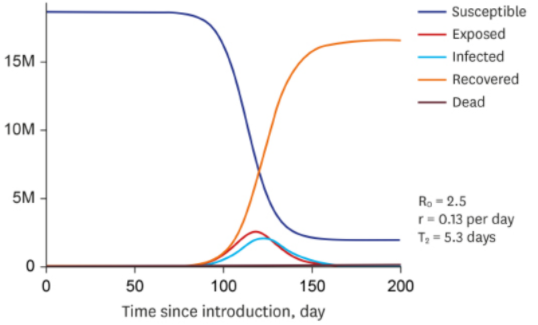

#**Model Overview**

In [12]:
#inputting fixed parameters based on date chosen

#2020-3-24: national emergency started

# state: S, E, I, R, 
# according to the data on the initial date:
# N: total population of LA county
N = 10039107                 
# E0: initial value of exposed group 
#     (half cases of 2020-3-24 in the LA county data) 
E0 = 335
# I0: initial value of infectious group 
#     (half cases of 2020-3-24 in the LA county data) 
I0 = 335
# Dead0: initial value of removed group
#       (from the death number of 2020-3-24 in the LA county data)
Dead0 = 10

S0 = N - E0 - I0
R0 = Dead0   #shall include recovered cases
#1.It is hard to tell if patients are really recovered
#2.It is rumored that recovered patients are still infectious

In [13]:

#note: these are assumed numbers for they are changing over time

beta = 0.2
#Probability of disease transmission per contact (dimensionless) times 
#the number of contacts per unit time.
#more contacts * the closer per contact 

delta = 1.0 / 5 # incubation period of 5 days


D = 8.0 # assuming infections lasts 8 days to get cured
gamma = 1.0 / D 


#beta = R_0 * gamma    # R0: reprodution number

#the average number of people infected from one other person

# R_0 = beta / gamma, so beta = R_0 * gamma


t = range(1,222) # Grid of time points (in days), from Mar 24 to Oct 30

y0 = S0, E0, I0, R0 # Initial conditions vector, from

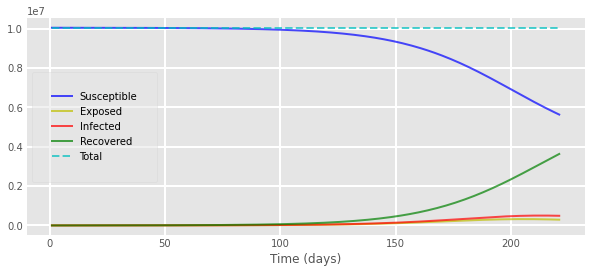

In [14]:
#actually Running the model

# Integrate the SEIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma, delta))
S, E, I, R = ret.T

plotseird(t, S, E, I, R)

In [15]:
#collect the data from simulation

SEIR = pd.DataFrame({'S':S, 'E':E, 'I':I, 'R':R, 'days':t})

SEIR['S'] = SEIR['S'].astype('int')
SEIR['E'] = SEIR['E'].astype('int')
SEIR['I'] = SEIR['I'].astype('int')
SEIR['R'] = SEIR['R'].astype('int')

SEIR['Total_confirmed'] = N-SEIR['S']
#Susceptible group is the only clear group

SEIR = SEIR.set_index(la_cases.index)

SEIR

,S,E,I,R,days,Total_confirmed
date,,,,,,
2020-03-24,10038437,335,335,10,1,670
2020-03-25,10038367,337,358,53,2,740
2020-03-26,10038293,343,380,99,3,814
2020-03-27,10038215,351,401,148,4,892
2020-03-28,10038133,362,421,199,5,974
...,...,...,...,...,...,...
2020-10-26,5855550,303818,497616,3382130,217,4183557
2020-10-27,5797878,301005,495997,3444235,218,4241229
2020-10-28,5740979,298000,494021,3506115,219,4298128


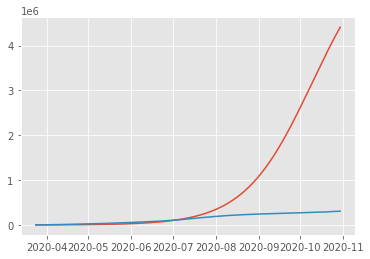

In [16]:
#Comparing two lines 

plt.plot(SEIR['Total_confirmed'])
plt.plot(la_cases['confirmed_cases'])

You may have noticed that we are not having the death numbers in this model. That's mainly because the epidemic is very complicated, it is hard to make both predictions accurate to push on two directions at the same time. This model is mainly for predicting new confirmed cases.

 We would have another model including the death cases in the end of this file, which is an extension of the current model and mainly focusing on predicting death cases. The two models are very similar.

# **Model 1, short term**

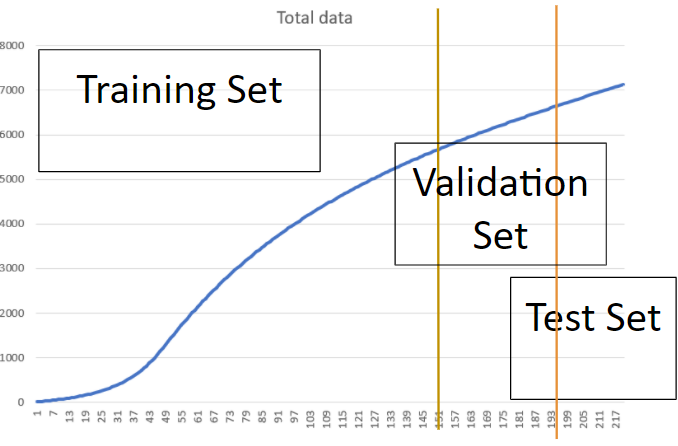

We are taking a big portion of data as traning set for training, then two smaller portions as the validation set and test set. (See chart above)



##Step 1, set up the time period you want



In [17]:
#say you want a model trained by data from  the first month after the national emergency, 
#and tested for data for last week of that month

total_t = 30
test_t = 7

#assuming a training set of 16 days and a validation set of 1 week

training_t = 16
validation_t = 7

la_cases_2 = la_cases[:total_t-test_t]
la_cases_test = la_cases[:total_t]
la_cases_2

,county,confirmed_cases,deaths
date,,,
2020-03-24,Los Angeles,670,10
2020-03-25,Los Angeles,814,13
2020-03-26,Los Angeles,1230,21
2020-03-27,Los Angeles,1482,26
2020-03-28,Los Angeles,1818,32
2020-03-29,Los Angeles,2147,37
2020-03-30,Los Angeles,2505,44
2020-03-31,Los Angeles,3037,54
2020-04-01,Los Angeles,3528,66


Very importanly, update the E0, I0, Dead0 when you change the base date

In [18]:
#     (half cases of 2020-03-24 in the LA county data) 
E0 = 335
# I0: initial value of infecious group 
#     (half cases of 2020-03-24 in the LA county data) 
I0 = 335
# Dead0: initial value of deceased group
#       (from the death number of 2020-08-02 in the LA county data)
Dead0 = 10

N = 10039107   

S0 = N - E0 - I0
R0 = Dead0


##Step 2, set up ranges for parameters to select models

You could set up the range by theories and other knowledge you knew, like the incubation period, it is typically like 5 days, so you could try a range around 0.2, which is 1/5. Then a range of (0.1,0.3,0.02) could be considered. If you could have a very good guess on the possible range of parameters, it would be very easy to finish this step.

But if you can't have a proper guess, you might need to be very patient on this step espicially when you want to change the time period to create a new model. Don't worry, there will be some tricks discussed later.

In [19]:
np.arange(0.1,0.3,0.02)

array([0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 , 0.22, 0.24, 0.26, 0.28])

In [20]:

import numpy as np


#set up the preferred range

beta_range = np.arange(0,1,0.05)     #start,end,interval
delta_range = np.arange(0,1,0.05)
gamma_range = np.arange(0,1,0.05)       



#trick 1
#better estimate your range first, or it might create too many or too few combinations for you

#e.g.
#beta range: 20
#delta range: 20
#gamma range: 20
#20*20*20 = 8000, so we will have 8000 rows in the end
#usually we will need at least 1,000, maybe 10,000 trials, but this range also depends on your actual needs
#if you could have more parameters, your model size could go up very easily

###########################################################################

t_2 = range(training_t+validation_t) # Grid of time points (in days)
#this is the number of days for the range of training and validation

#sometime better remember what really size we have for the three sets
#we had training for 16, validation for 7, and 7

y_2 = S0, E0, I0, R0 # Initial conditions vector


#Our goal is to generate the training loss and validation loss for each of the combination of parameters.
#just like grid search

#empty lists for taking values
gamma_list = []
delta_list = []
beta_list = []
error_training_list = []
error_validation_list = []

import statistics  #to handle the mean function

for gamma in gamma_range:
  for delta in delta_range:
    for beta in beta_range:
      # Integrate the SIR equations over the time grid, t.
      ret = odeint(deriv, y_2, t_2, args=(N, beta, gamma, delta))
      S, E, I, R = ret.T

      SEIR_2 = pd.DataFrame({'S':S, 'E':E, 'I':I, 'R':R, 'days':t_2})

      SEIR_2['S'] = SEIR_2['S'].astype('int')
      SEIR_2['E'] = SEIR_2['E'].astype('int')
      SEIR_2['I'] = SEIR_2['I'].astype('int')
      SEIR_2['R'] = SEIR_2['R'].astype('int')

      SEIR_2['Total_confirmed'] = N-SEIR_2['S']
      #Susceptible group is the only clear group

      SEIR_2 = SEIR_2.set_index(la_cases_2.index)


      #loss functions: Mean Square Error
      error_training = statistics.mean((SEIR_2['Total_confirmed'][0:training_t]-la_cases_2['confirmed_cases'][0:training_t])**2) 
      error_validation = statistics.mean((SEIR_2['Total_confirmed'][training_t:training_t+validation_t]
                                          -la_cases_2['confirmed_cases'][training_t:training_t+validation_t])**2)

      #sometimes you may need a combined loss function to fulfill your different needs
      #but when you are using multiple loss functions, 
      #estimate their result ranges first to balance the weights of the loss functions

      gamma_list.append(gamma)
      delta_list.append(delta)
      beta_list.append(beta)
      error_training_list.append(error_training)
      error_validation_list.append(error_validation)

data_dict = {'beta':beta_list,'gamma':gamma_list,'delta':delta_list,
             'error_training':error_training_list, 'error_validation':error_validation_list}

comparison = pd.DataFrame(data_dict)
base_models = comparison.sort_values(by='error_training')
#we are looking for the best performed models on training error
base_models

,beta,gamma,delta,error_training,error_validation
5095,0.75,0.60,0.70,1.763856e+04,8.124791e+06
5496,0.80,0.65,0.70,1.814644e+04,8.157952e+06
6679,0.95,0.80,0.65,1.863956e+04,4.415214e+06
5996,0.80,0.70,0.95,2.011269e+04,3.212421e+06
6278,0.90,0.75,0.65,2.030550e+04,4.521538e+06
...,...,...,...,...,...
339,0.95,0.00,0.80,5.244988e+11,5.940615e+13
398,0.90,0.00,0.95,5.833191e+11,6.082583e+13
359,0.95,0.00,0.85,6.616770e+11,6.329254e+13
379,0.95,0.00,0.90,8.192624e+11,6.678563e+13


Trick 2: see how the values are getting together in the top and bottom several rows, then change the range for the certain parameter.

e.g.The beta range below is (0.2, 0.4), but the beta for top models is 0.38 and 0.2 for bottom models. Then you know you should try to move your beta range higher, like (0.3,0.5), in order to get a better result of the models selected.

You could also set up a larger range for all parameters to have more results sorted, but the more results you are looking for, the more time it would take.

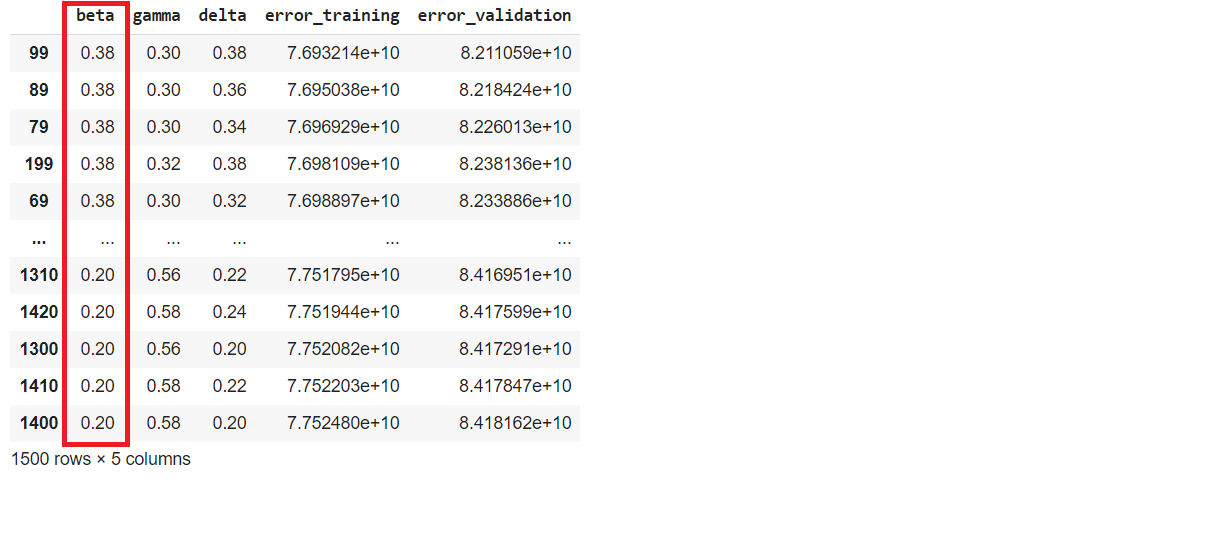

Trick 3: You could mark down the lowest training error number you get, then when you make a change on the range of parameters, take a look at the new training error and compare, so you could see if your changes are going on a right direction.


Trick 4: You can always check the model by codes below by inputting the parameters yourself.

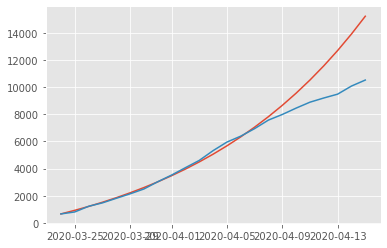

In [21]:
#Try the Top combination of parameters here and see its performance

ret_2 = odeint(deriv, y_2, t_2, args=(N, 0.75, 0.6, 0.7))  #beta, gamma, delta

##########################################################################


S_2, E_2, I_2, R_2 = ret_2.T

SEIR_2 = pd.DataFrame({'S':S_2, 'E':E_2, 'I':I_2, 'R':R_2, 'days':t_2})

SEIR_2['S'] = SEIR_2['S'].astype('int')
SEIR_2['E'] = SEIR_2['E'].astype('int')
SEIR_2['I'] = SEIR_2['I'].astype('int')
SEIR_2['R'] = SEIR_2['R'].astype('int')

SEIR_2['Total_confirmed'] = N-SEIR_2['S']

SEIR_2 = SEIR_2.set_index(la_cases_2.index)
plt.plot(SEIR_2['Total_confirmed'])
plt.plot(la_cases_2['confirmed_cases'])

Sometimes you may go too far and overfit the model in the training set, so it is always good to check on this chart.

We now choose the best performed 1000 models in training set. We will choose the final models from them by validation loss in the next step.


In [22]:
good_models = base_models[:1000] #you could only take more or less of the models
best_models = good_models.sort_values(by='error_validation')[0:10]
best_models

,beta,gamma,delta,error_training,error_validation
7099,0.95,0.85,0.70,226884.7500,256488.142857
6698,0.90,0.80,0.70,271047.0625,291161.571429
5916,0.80,0.70,0.75,247698.7500,328210.714286
6317,0.85,0.75,0.75,191927.0625,338996.428571
6297,0.85,0.75,0.70,325844.6250,342919.857143
5515,0.75,0.65,0.75,319595.4375,343435.000000
6718,0.90,0.80,0.75,149022.1250,368547.000000
5114,0.70,0.60,0.75,411098.1875,397031.285714
7119,0.95,0.85,0.75,116767.1875,409657.857143
4733,0.65,0.55,0.80,383633.9375,416426.285714


To some extent, it would be good to see the validation error is similar to the training error, so we know it is not overfitting on a single part

##Step 3, give the models a weight to decide the final prediction

In [23]:
#here is just a rank method, you could develop your own methods
#rank no.1 get 10 pts, no.2 get 9 pts...55 pts total

best_models['rank'] = best_models['error_validation'].rank()
#rank() returns a list of rankings in numbers for a column/row
#this time ranking is based on the validation error

best_models['points'] = 11-best_models['rank']
#no.1 get 10, no.2 gets 9... no.10 gets 1
#the sum of the points and the ranking is always 11

best_models['weights'] = best_models['points']/55

best_models

,beta,gamma,delta,error_training,error_validation,rank,points,weights
7099,0.95,0.85,0.70,226884.7500,256488.142857,1.0,10.0,0.181818
6698,0.90,0.80,0.70,271047.0625,291161.571429,2.0,9.0,0.163636
5916,0.80,0.70,0.75,247698.7500,328210.714286,3.0,8.0,0.145455
6317,0.85,0.75,0.75,191927.0625,338996.428571,4.0,7.0,0.127273
6297,0.85,0.75,0.70,325844.6250,342919.857143,5.0,6.0,0.109091
5515,0.75,0.65,0.75,319595.4375,343435.000000,6.0,5.0,0.090909
6718,0.90,0.80,0.75,149022.1250,368547.000000,7.0,4.0,0.072727
5114,0.70,0.60,0.75,411098.1875,397031.285714,8.0,3.0,0.054545
7119,0.95,0.85,0.75,116767.1875,409657.857143,9.0,2.0,0.036364
4733,0.65,0.55,0.80,383633.9375,416426.285714,10.0,1.0,0.018182


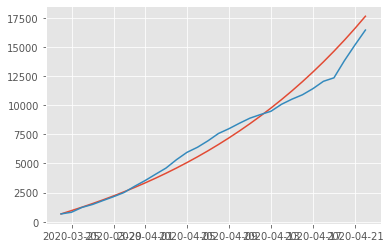

In [24]:
#predict

#notice that we are preparing a blank list for multiple values, length of total_t

S_test = [0]*total_t
E_test = [0]*total_t
I_test = [0]*total_t
R_test = [0]*total_t

t_test = range(total_t)

for index in best_models.index:
  ret_2 = odeint(deriv, y_2, t_test, args=(N, best_models['beta'][index], best_models['gamma'][index],
                                        best_models['delta'][index]))  #beta, gamma, delta
  S_2, E_2, I_2, R_2 = ret_2.T

  #result * weight
  S_test = S_test + S_2 * best_models['weights'][index]
  E_test = E_test + E_2 * best_models['weights'][index]
  I_test = I_test + I_2 * best_models['weights'][index]
  R_test = R_test + R_2 * best_models['weights'][index]
  
SEIR_2 = pd.DataFrame({'S':S_test, 'E':E_test, 'I':I_test, 'R':R_test, 'days':t_test})

SEIR_2['S'] = SEIR_2['S'].astype('int')
SEIR_2['E'] = SEIR_2['E'].astype('int')
SEIR_2['I'] = SEIR_2['I'].astype('int')
SEIR_2['R'] = SEIR_2['R'].astype('int')

SEIR_2['Total_confirmed'] = N-SEIR_2['S']

SEIR_2 = SEIR_2.set_index(la_cases_test.index)
plt.plot(SEIR_2['Total_confirmed'])
plt.plot(la_cases_test['confirmed_cases'])


#**Model 2, long term**

In [25]:
la_cases.shape

(221, 3)

In [26]:
total_t = 221

#say we want to have validation set and test set for a month of 30 daysa
test_t = 30
validation_t = 30
training_t = 161

la_cases_3 = la_cases[-total_t:-test_t]
la_cases_test = la_cases[-total_t:]
la_cases_3

,county,confirmed_cases,deaths
date,,,
2020-03-24,Los Angeles,670,10
2020-03-25,Los Angeles,814,13
2020-03-26,Los Angeles,1230,21
2020-03-27,Los Angeles,1482,26
2020-03-28,Los Angeles,1818,32
...,...,...,...
2020-09-26,Los Angeles,267028,6504
2020-09-27,Los Angeles,267807,6514
2020-09-28,Los Angeles,268501,6515


In [27]:
#     (half cases of 2020-03-24 in the LA county data) 
E0 = 335
# I0: initial value of infecious group 
#     (half cases of 2020-03-24 in the LA county data) 
I0 = 335
# Dead0: initial value of deceased group
#       (from the death number of 2020-03-24 in the LA county data)
Dead0 = 10

N = 10039107   

S0 = N - E0 - I0
R0 = Dead0


In [28]:

import numpy as np

#set up the preferred range

beta_range = np.arange(0,1,0.05)     #start,end,interval
delta_range = np.arange(0,1,0.05)
gamma_range = np.arange(0,1,0.05)       


t_3 = range(training_t+validation_t) # Grid of time points (in days)
#this is the number of days for the range of training and validation

#sometime better remember what really size we have for the three sets

y_3 = S0, E0, I0, R0 # Initial conditions vector


#empty lists for taking values
gamma_list = []
delta_list = []
beta_list = []
error_training_list = []
error_validation_list = []

import statistics  #to handle the mean function

for gamma in gamma_range:
  for delta in delta_range:
    for beta in beta_range:
      # Integrate the SIR equations over the time grid, t.
      ret = odeint(deriv, y_3, t_3, args=(N, beta, gamma, delta))
      S, E, I, R = ret.T

      SEIR_3 = pd.DataFrame({'S':S, 'E':E, 'I':I, 'R':R, 'days':t_3})

      SEIR_3['S'] = SEIR_3['S'].astype('int')
      SEIR_3['E'] = SEIR_3['E'].astype('int')
      SEIR_3['I'] = SEIR_3['I'].astype('int')
      SEIR_3['R'] = SEIR_3['R'].astype('int')

      SEIR_3['Total_confirmed'] = N-SEIR_3['S']

      SEIR_3 = SEIR_3.set_index(la_cases_3.index)

      error_training = statistics.mean((SEIR_3['Total_confirmed'][0:training_t]-la_cases['confirmed_cases'][0:training_t])**2) #Mean Square Error
      error_validation = statistics.mean((SEIR_3['Total_confirmed'][training_t:training_t+validation_t]-la_cases['confirmed_cases'][training_t:training_t+validation_t])**2) #Mean Square Error

      #sometimes you may need a compined loss function to fulfill your different needs
      #but when you are using multiple loss fuctions, estimate their result ranges first to balance the weights of the loss functions

      gamma_list.append(gamma)
      delta_list.append(delta)
      beta_list.append(beta)
      error_training_list.append(error_training)
      error_validation_list.append(error_validation)

data_dict = {'beta':beta_list,'gamma':gamma_list,'delta':delta_list,
             'error_training':error_training_list, 'error_validation':error_validation_list}

comparison = pd.DataFrame(data_dict)
base_models = comparison.sort_values(by='error_training')
#we are looking for the best performed models on training error
base_models

,beta,gamma,delta,error_training,error_validation
7499,0.95,0.90,0.70,2.400910e+08,1.607057e+10
6677,0.85,0.80,0.65,3.046740e+08,1.779905e+10
7098,0.90,0.85,0.70,3.090616e+08,2.240520e+10
7078,0.90,0.85,0.65,3.109237e+08,1.210952e+10
7479,0.95,0.90,0.65,3.660062e+08,8.026445e+09
...,...,...,...,...,...
339,0.95,0.00,0.80,8.714008e+13,9.569899e+13
398,0.90,0.00,0.95,8.720725e+13,9.569899e+13
359,0.95,0.00,0.85,8.732742e+13,9.569899e+13
379,0.95,0.00,0.90,8.749815e+13,9.569899e+13


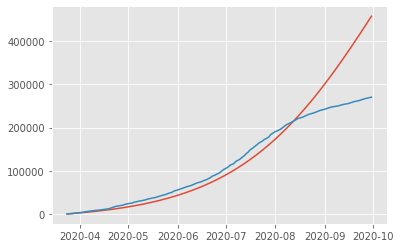

In [29]:
#Try the Top combination of parameters here and see its performance

ret_3 = odeint(deriv, y_3, t_3, args=(N, 0.95, 0.9, 0.7))  #beta, gamma, delta

##########################################################################


S_3, E_3, I_3, R_3 = ret_3.T

SEIR_3 = pd.DataFrame({'S':S_3, 'E':E_3, 'I':I_3, 'R':R_3, 'days':t_3})

SEIR_3['S'] = SEIR_3['S'].astype('int')
SEIR_3['E'] = SEIR_3['E'].astype('int')
SEIR_3['I'] = SEIR_3['I'].astype('int')
SEIR_3['R'] = SEIR_3['R'].astype('int')

SEIR_3['Total_confirmed'] = N-SEIR_3['S']

SEIR_3 = SEIR_3.set_index(la_cases_3.index)
plt.plot(SEIR_3['Total_confirmed'])
plt.plot(la_cases_3['confirmed_cases'])

In [30]:
good_models = base_models[:6000] #you could change to the number you want here

best_models = good_models.sort_values(by='error_validation')[0:10]
best_models

,beta,gamma,delta,error_training,error_validation
7439,0.95,0.90,0.55,1.460375e+09,6.773414e+08
6617,0.85,0.80,0.50,1.865481e+09,6.797597e+08
5795,0.75,0.70,0.45,2.338370e+09,8.593239e+08
7018,0.90,0.85,0.50,2.127718e+09,8.659053e+08
5394,0.70,0.65,0.45,2.010426e+09,9.624037e+08
4572,0.60,0.55,0.40,2.475406e+09,9.833666e+08
6216,0.80,0.75,0.50,1.598985e+09,1.066457e+09
3750,0.50,0.45,0.35,2.982601e+09,1.132703e+09
4973,0.65,0.60,0.40,2.880542e+09,1.263910e+09
7038,0.90,0.85,0.55,1.244143e+09,1.267502e+09


In [31]:
#here is just a rank method, you could develop your own methods
#rank no.1 get 10 pts, no.2 get 9 pts...55 pts total


best_models['rank'] = best_models['error_validation'].rank()
#rank() returns a list of rankings in numbers for a column/row


best_models['points'] = 11-best_models['rank']
#no.1 get 10, no.2 gets 9... no.10 gets 1

best_models['weights'] = best_models['points']/55

best_models

,beta,gamma,delta,error_training,error_validation,rank,points,weights
7439,0.95,0.90,0.55,1.460375e+09,6.773414e+08,1.0,10.0,0.181818
6617,0.85,0.80,0.50,1.865481e+09,6.797597e+08,2.0,9.0,0.163636
5795,0.75,0.70,0.45,2.338370e+09,8.593239e+08,3.0,8.0,0.145455
7018,0.90,0.85,0.50,2.127718e+09,8.659053e+08,4.0,7.0,0.127273
5394,0.70,0.65,0.45,2.010426e+09,9.624037e+08,5.0,6.0,0.109091
4572,0.60,0.55,0.40,2.475406e+09,9.833666e+08,6.0,5.0,0.090909
6216,0.80,0.75,0.50,1.598985e+09,1.066457e+09,7.0,4.0,0.072727
3750,0.50,0.45,0.35,2.982601e+09,1.132703e+09,8.0,3.0,0.054545
4973,0.65,0.60,0.40,2.880542e+09,1.263910e+09,9.0,2.0,0.036364
7038,0.90,0.85,0.55,1.244143e+09,1.267502e+09,10.0,1.0,0.018182


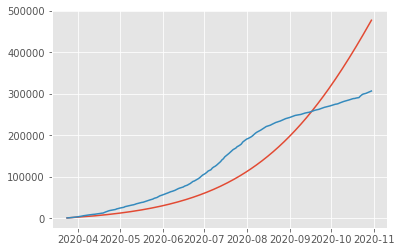

In [32]:
#predict


#notice that we are preparing a blank list for multiple values, and we our data range is total_t
S_test = [0]*total_t
E_test = [0]*total_t
I_test = [0]*total_t
R_test = [0]*total_t

t_test = range(total_t)

for index in best_models.index:
  ret_3 = odeint(deriv, y_3, t_test, args=(N, best_models['beta'][index], best_models['gamma'][index],
                                        best_models['delta'][index]))  #beta, gamma, delta
  S_3, E_3, I_3, R_3 = ret_3.T
  S_test = S_test + S_3 * best_models['weights'][index]
  E_test = E_test + E_3 * best_models['weights'][index]
  I_test = I_test + I_3 * best_models['weights'][index]
  R_test = R_test + R_3 * best_models['weights'][index]
  
SEIR_3 = pd.DataFrame({'S':S_test, 'E':E_test, 'I':I_test, 'R':R_test, 'days':t_test})

SEIR_3['S'] = SEIR_3['S'].astype('int')
SEIR_3['E'] = SEIR_3['E'].astype('int')
SEIR_3['I'] = SEIR_3['I'].astype('int')
SEIR_3['R'] = SEIR_3['R'].astype('int')

SEIR_3['Total_confirmed'] = N-SEIR_3['S']

SEIR_3 = SEIR_3.set_index(la_cases.index)
plt.plot(SEIR_3['Total_confirmed'])
plt.plot(la_cases['confirmed_cases'])


# **Model for death cases**

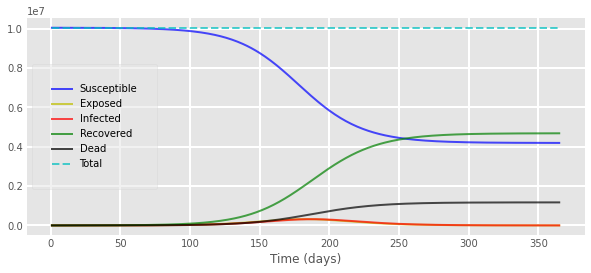

In [33]:
def deriv_death(y, t, N, beta, gamma, delta, alpha):    #alpha:fatal rate
    S, E, I, R, D= y
    dSdt = -beta * S * I / N
    dEdt = beta * S * I / N - delta * E
    dIdt = delta * E - gamma * I
    dRdt = gamma * I * (1-alpha)                     
    dDdt = gamma * I * alpha                         #main change
    return dSdt, dEdt, dIdt, dRdt, dDdt

y_4 = S0, E0, I0, R0, Dead0                       # taking the initial deaths

t_4 = range(1,366)
# assume a year for visualization

alpha = 0.2                  
# assume a rate of 0.2 for visualization

#made-up numbers for visualization
beta = 0.3
gamma = 0.2
delta = 0.2


ret = odeint(deriv_death, y_4, t_4, args=(N, beta, gamma, delta, alpha))   #adding the alpha
S_4, E_4, I_4, R_4, D_4= ret.T

plotseird(t_4, S_4, E_4, I_4, R_4, D_4)

In [34]:
SEIR_4 = pd.DataFrame({'S':S_4, 'E':E_4, 'I':I_4, 'R':R_4, 'D':D_4, 'days':t_4})

SEIR_4['S'] = SEIR_4['S'].astype('int')
SEIR_4['E'] = SEIR_4['E'].astype('int')
SEIR_4['I'] = SEIR_4['I'].astype('int')
SEIR_4['R'] = SEIR_4['R'].astype('int')
SEIR_4['D'] = SEIR_4['D'].astype('int')

SEIR_4['Total_confirmed'] = N-SEIR_4['S']


SEIR_4

,S,E,I,R,D,days,Total_confirmed
0,10038437,335,335,10,10,1,670
1,10038336,365,337,63,23,2,771
2,10038233,392,345,118,37,3,874
3,10038128,416,356,174,51,4,979
4,10038019,439,369,232,65,5,1088
...,...,...,...,...,...,...,...
360,4190056,687,869,4678004,1169508,361,5849051
361,4189950,659,833,4678140,1169542,362,5849157
362,4189848,632,799,4678271,1169575,363,5849259
363,4189749,606,767,4678396,1169606,364,5849358
